In [ ]:
# Импорт pyspiel and показ поддерживаемых игр
!pip install --upgrade open_spiel
import pyspiel

In [3]:
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.pytorch import dqn as dqn_pt
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent
import pickle
from random import sample

Instructions for updating:
non-resource variables are not supported in the long term


#TIC-TAC-TOE

In [3]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [25]:
checkpoint_dir = "/tmp/dqn_test"
num_train_episodes = 10000
eval_every = 100

hidden_layers_sizes = [64, 64]
replay_buffer_capacity = int(1e5)
batch_size = 32

In [26]:
game = "tic_tac_toe"
config = {}
num_train_episodes = 200000
eval_every = 1000

In [27]:
num_players = 2

env = rl_environment.Environment(game, **config)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

# random agents for evaluation
random_agents = [
    random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]


hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
# pylint: disable=g-complex-comprehension
agents = [
    dqn_pt.DQN(
        player_id=idx,
        state_representation_size=info_state_size,
        num_actions=num_actions,
        hidden_layers_sizes=hidden_layers_sizes,
        replay_buffer_capacity=replay_buffer_capacity,
        batch_size=batch_size) for idx in range(num_players)
]
result = []

In [28]:
import pickle

for ep in range(num_train_episodes):
  if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      result.append(r_mean)
      print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

  if (ep + 1) % 40000 == 0:
    with open(f'drive/MyDrive/My/DeepMind DQN/agents_TIC-TAC-TOE_{ep + 1}.pt', 'wb') as f:
      pickle.dump(agents, f)
      
  time_step = env.reset()
  while not time_step.last():
      player_id = time_step.observations["current_player"]
      agent_output = agents[player_id].step(time_step)
      action_list = [agent_output.action]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
  for agent in agents:
      agent.step(time_step)

[1000] Mean episode rewards [ 0.613 -0.059]
[2000] Mean episode rewards [ 0.489 -0.014]
[3000] Mean episode rewards [0.586 0.179]
[4000] Mean episode rewards [0.658 0.141]
[5000] Mean episode rewards [0.65  0.283]
[6000] Mean episode rewards [0.73  0.268]
[7000] Mean episode rewards [0.734 0.36 ]
[8000] Mean episode rewards [0.676 0.407]
[9000] Mean episode rewards [0.626 0.344]
[10000] Mean episode rewards [0.699 0.428]
[11000] Mean episode rewards [0.655 0.409]
[12000] Mean episode rewards [0.813 0.442]
[13000] Mean episode rewards [0.721 0.465]
[14000] Mean episode rewards [0.846 0.428]
[15000] Mean episode rewards [0.831 0.374]
[16000] Mean episode rewards [0.758 0.412]
[17000] Mean episode rewards [0.806 0.432]
[18000] Mean episode rewards [0.775 0.496]
[19000] Mean episode rewards [0.856 0.446]
[20000] Mean episode rewards [0.84 0.36]
[21000] Mean episode rewards [0.853 0.373]
[22000] Mean episode rewards [0.881 0.405]
[23000] Mean episode rewards [0.883 0.436]
[24000] Mean episo

In [ ]:
with open('drive/MyDrive/agents_TIC-TAC-TOE.pt', 'wb') as f:
    pickle.dump(agents, f)

In [ ]:
with open('drive/MyDrive/agents_TIC-TAC-TOE.pt', 'rb') as f:
    Agents = pickle.load(f)

In [ ]:
# Проверка качества игры. Игра с человеком

MY_TURN = 1
RIVAL_TURN = 0

time_step = env.reset()
print(env.get_state)
print()
while not time_step.last():
    player_id = time_step.observations["current_player"]
    if player_id == RIVAL_TURN:
        agent_output = Agents[player_id].step(time_step)
        action_list = [agent_output.action]
    elif player_id == MY_TURN:
        print('Введите ход (строка, столбец):')
        row, col = map(int, input().split())
        action_list = [3 * (row - 1) + (col - 1)]
    time_step = env.step(action_list)
    print(env.get_state)
    print()
for agent in Agents:
    agent.step(time_step)

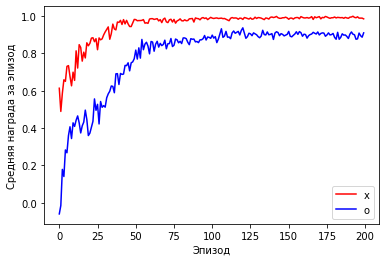

In [29]:
import matplotlib.pyplot as plt

pt_result = result
ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за эпизод')
plt.legend(['x', 'o'])
plt.show()

#BREAKTHROUGH

In [4]:
game = "breakthrough"
config = {"columns": 5, "rows": 5}

In [5]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [6]:
checkpoint_dir = "/tmp/dqn_test"
num_train_episodes = 100000
eval_every = 100

hidden_layers_sizes = [64, 64]
replay_buffer_capacity = int(1e5)
batch_size = 32

In [7]:
num_players = 2

env = rl_environment.Environment(game, **config)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

# random agents for evaluation
random_agents = [
    random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]


hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
# pylint: disable=g-complex-comprehension
agents = [
          dqn_pt.DQN(
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
]
result = []

In [14]:
for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
        r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
        result.append(r_mean)
        print("[%s] Mean episode rewards %s" %(ep + 1, r_mean))

    if (ep + 1) % 20000 == 0:
        with open(f'drive/MyDrive/My/DeepMind DQN/agents_BREAKTHROUGH_{ep + 1}.pt', 'wb') as f:
            pickle.dump(agents, f)

    time_step = env.reset()
    while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
            agent_output = agents[player_id].step(time_step)
            action_list = [agent_output.action]
        else:
            agents_output = [agent.step(time_step) for agent in agents]
            action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
        agent.step(time_step)
#result, env, agents

[100] Mean episode rewards [0.594 0.406]
[200] Mean episode rewards [0.508 0.316]
[300] Mean episode rewards [0.484 0.172]
[400] Mean episode rewards [0.438 0.02 ]
[500] Mean episode rewards [0.462 0.064]
[600] Mean episode rewards [ 0.472 -0.042]
[700] Mean episode rewards [ 0.326 -0.15 ]
[800] Mean episode rewards [ 0.432 -0.092]
[900] Mean episode rewards [ 0.43 -0.12]
[1000] Mean episode rewards [ 0.282 -0.134]
[1100] Mean episode rewards [ 0.308 -0.09 ]
[1200] Mean episode rewards [ 0.164 -0.114]
[1300] Mean episode rewards [ 0.332 -0.156]
[1400] Mean episode rewards [ 0.268 -0.102]
[1500] Mean episode rewards [ 0.28  -0.092]
[1600] Mean episode rewards [ 0.41  -0.042]
[1700] Mean episode rewards [ 0.548 -0.01 ]
[1800] Mean episode rewards [0.65  0.088]
[1900] Mean episode rewards [0.476 0.11 ]
[2000] Mean episode rewards [0.498 0.088]
[2100] Mean episode rewards [0.466 0.204]
[2200] Mean episode rewards [0.354 0.138]
[2300] Mean episode rewards [0.29 0.13]
[2400] Mean episode rew

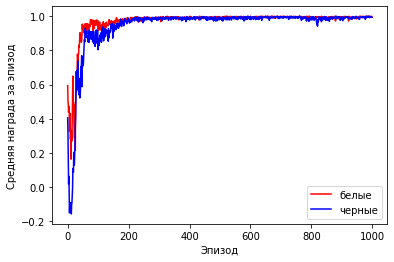

In [21]:
import matplotlib.pyplot as plt

pt_result = result

ep = [x for x in range(len(pt_result))]
pt_r_mean0 = [y[0] for y in pt_result]
pt_r_mean1 = [y[1] for y in pt_result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за эпизод')
plt.legend(['белые', 'черные'])
plt.show()

In [15]:
import pickle
with open('drive/MyDrive/agents_BREAKTHROUGH_100000.pt', 'wb') as f:
    pickle.dump(agents, f)

In [ ]:
import pickle
with open('drive/MyDrive/agents_BREAKTHROUGH.pt', 'rb') as f:
    Agents = pickle.load(f)

In [ ]:
# Проверка качества игры. Игра с человеком

MY_TURN = 0
RIVAL_TURN = 1

time_step = env.reset()
print(env.get_state)
while not time_step.last():
    player_id = time_step.observations["current_player"]
    print(time_step.observations["legal_actions"][player_id])
    if player_id == RIVAL_TURN:
        agent_output = Agents[player_id].step(time_step)
        action_list = [agent_output.action]
    elif player_id == MY_TURN:
        action_list = [int(input())]
    time_step = env.step(action_list)
    print(env.get_state)
    print()
for agent in Agents:
    agent.step(time_step)

In [38]:
# Игра между моделями на разных стадиях обучения

ep_w = 100000
ep_b = 100000
we = 0

with open(f'drive/MyDrive/My/DeepMind DQN/agents_BREAKTHROUGH_{ep_w}.pt', 'rb') as f:
    x_agents = pickle.load(f)
with open(f'drive/MyDrive/My/DeepMind DQN/agents_BREAKTHROUGH_{ep_b}.pt', 'rb') as f:
    o_agents = pickle.load(f)
agents = [x_agents[0], o_agents[1]]

In [44]:
wins = 0
losses = 0
draws = 0

for _ in range(1000):
    time_step = env.reset()
    #print(env.get_state)

    #Первый ход случайный
    player_id = time_step.observations["current_player"]
    #print(time_step.observations["legal_actions"][player_id])
    rand_action = sample(time_step.observations["legal_actions"][player_id], 1)
    action_list = [rand_action[0]]
    time_step = env.step(action_list)
    #print(env.get_state)
    #print()

    while not time_step.last():
        player_id = time_step.observations["current_player"]
        #print(time_step.observations["legal_actions"][player_id])
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
        time_step = env.step(action_list)
        #print(env.get_state)
        #print()
    for agent in agents:
        agent.step(time_step)

    if time_step.rewards[we] == 1: wins += 1
    elif time_step.rewards[we] == -1: losses += 1
    elif time_step.rewards[we] == 0: draws += 1
print(wins, losses, draws)

576 424 0
